Parsed with column specification:
cols(
  `#OTU ID` = col_character(),
  F3D141 = col_integer(),
  F3D142 = col_integer(),
  F3D143 = col_integer(),
  F3D144 = col_integer(),
  F3D145 = col_integer(),
  F3D146 = col_integer(),
  F3D147 = col_integer(),
  F3D148 = col_integer(),
  F3D149 = col_integer(),
  F3D150 = col_integer()
)
Parsed with column specification:
cols(
  Sample_ID = col_character(),
  Treatment = col_character()
)
Parsed with column specification:
cols(
  `#OTU ID` = col_character(),
  Taxonomy = col_character()
)
Warning message:
“Column `Sample_ID` joining character vector and factor, coercing into character vector”Adding missing grouping variables: `Treatment`
Warning message:
“Expected 7 pieces. Additional pieces discarded in 730 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”Adding missing grouping variables: `Treatment`


[1] "Sample Composition completed Successfully.!!!"


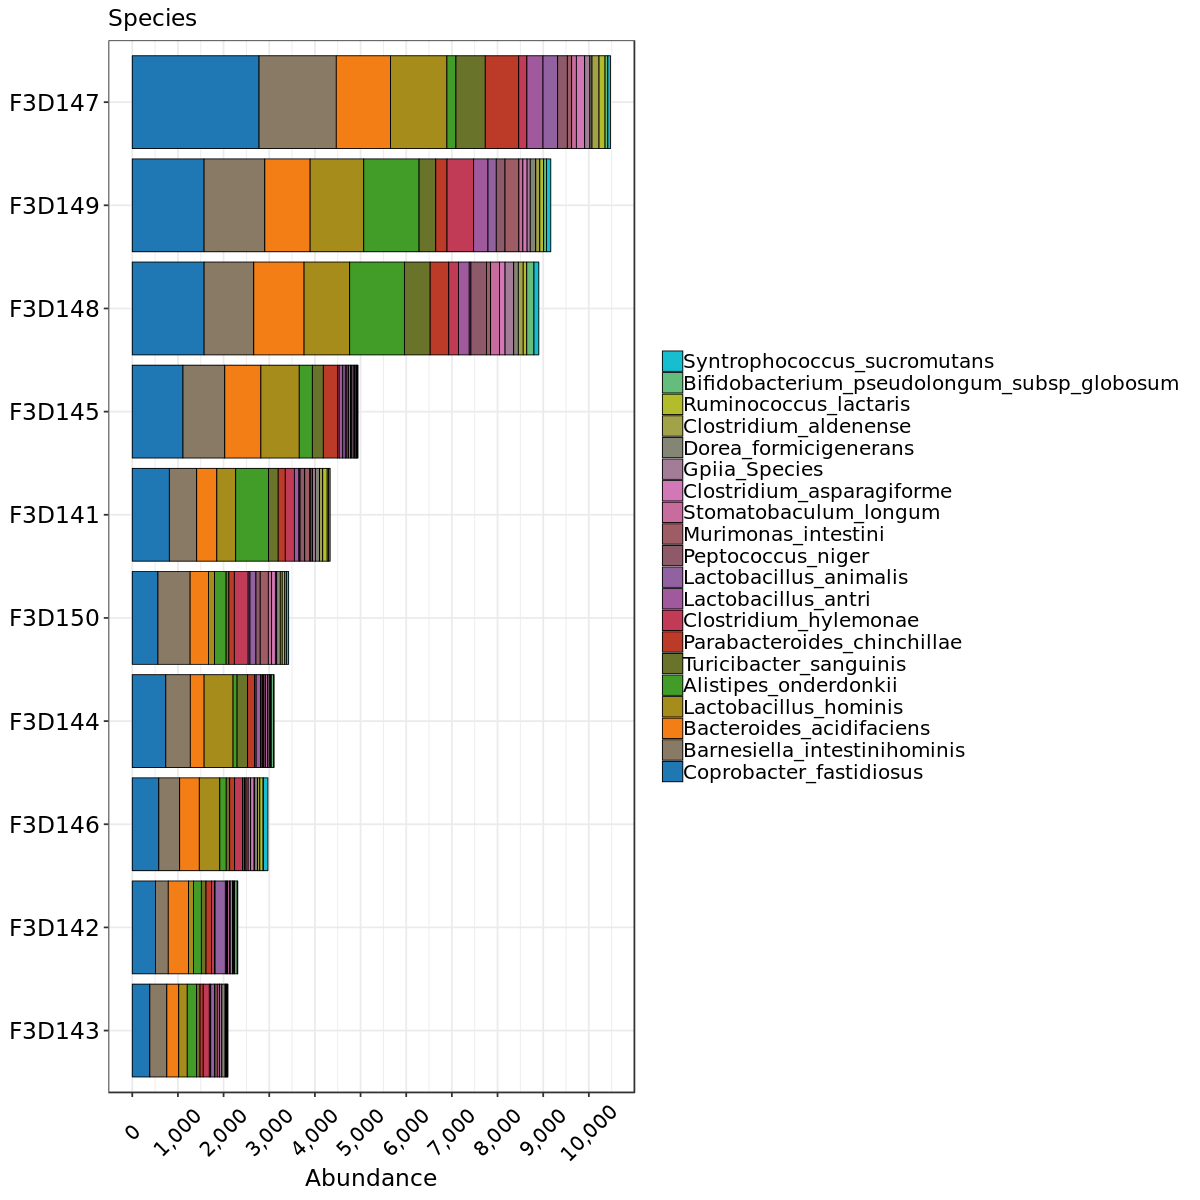

In [4]:
#####################
# Data Loading
#####################
library(tidyverse)
library(ggplot2)
library(reshape2)
library(cowplot)
library(gplots)
library(tools)
library(scales)
library(stringr)
library(RColorBrewer)
library(ggsci)
######################
#SETTING
args = commandArgs(trailingOnly=TRUE)
options(scipen=10000000)
Default_Pallett = c('#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf')
PLOTLY_Pallett = c('#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf')
JCO_Pallett = pal_jco("default")(10)
Default_Pallett = JCO_Pallett
theme_set(theme_bw(base_family = "Sans"))
OFFLINE_MODE=FALSE
if(OFFLINE_MODE==FALSE){
    options(repr.plot.width=10, repr.plot.height=10)
}
######################
#INPUT/OUTPUT
if(OFFLINE_MODE==FALSE){
    abundance_file_Path = "/data/shamsaddinisha/MBAC/MOTHUR/MISEQ_SOP/MISEQ_SOP_SMALL/Late/cluster/Late.OTU_abundance.txt"
    metadata_file_Path = "/data/shamsaddinisha/MBAC/MOTHUR/MISEQ_SOP/MISEQ_SOP_SMALL/Late/overview/Late_mothur_metadata.txt"
    taxonomy_file_Path = "/data/shamsaddinisha/MBAC/MOTHUR/MISEQ_SOP/MISEQ_SOP_SMALL/Late/cluster/Late.OTU_taxonomy.txt"
    taxonomic_composition_plot_output = "./Late.overview.taxonomic_composition.txt"
}else{
    abundance_file_Path = args[1]
    metadata_file_Path = args[2]
    taxonomy_file_Path = args[3]
    taxonomic_composition_plot_output = args[4]
}
#####################
#READ I/O
abundance_DF = read_tsv(abundance_file_Path)
#head(abundance_DF)
#dim(abundance_DF)
metadata_DF = read_tsv(metadata_file_Path)
#head(metadata_DF)
#dim(metadata_DF)
taxonomy_DF = read_tsv(taxonomy_file_Path)
#head(taxonomy_DF)
#dim(taxonomy_DF)
####################
#Data Wrangling
colnames(abundance_DF)[colnames(abundance_DF)=="#OTU ID"] <- "OTU_ID"
colnames(taxonomy_DF)[colnames(taxonomy_DF)=="#OTU ID"] <- "OTU_ID"
#OTU_COUNT_LIMIT
otu_count = length(unique(abundance_DF$OTU_ID))
if(otu_count <= 20){
    otu_count_limit = otu_count 
}else{
    otu_count_limit = 20
}
melted_abundance_DF = melt(abundance_DF, id.vars = c("OTU_ID"), variable.name = "Sample_ID", value.name="Abundance")
metadata_melted_abundance_DF = metadata_DF %>%
    left_join(melted_abundance_DF, by = c("Sample_ID" = "Sample_ID"))

#SAMPLE_COUNT_LIMIT
sample_count = length(unique(metadata_DF$Sample_ID))
if(sample_count <= 20){
    sample_count_limit = sample_count 
}else{
    sample_count_limit = 20
}
design_List = sort(unique(metadata_DF$Treatment))
design_list_Length = length(design_List)
#
for(each_design_index in 1:design_list_Length){
    #
    top_abundance_sample_List = metadata_melted_abundance_DF %>%
        select(c(Treatment, Sample_ID, Abundance)) %>%
        group_by(Treatment, Sample_ID) %>%
        summarise(Total_Abundance=sum(Abundance)) %>%
        arrange(-Total_Abundance)%>% 
        top_n(sample_count_limit, Total_Abundance) %>% 
        select(Sample_ID)
    #print(top_abundance_sample_List)
    #
    taxonomy_metadata_melted_abundance_DF = metadata_melted_abundance_DF %>%
        left_join(taxonomy_DF, by = c("OTU_ID" = "OTU_ID")) %>%
        separate(Taxonomy, into=c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"), sep = ";")
    #
    Lineage_List = c("Phylum", "Family", "Genus", "Species")
    #Lineage_List = c("Species")
    Lineage_Length = length(Lineage_List)
    for(each_lineage in 1:Lineage_Length){
        #
        top_abundance_otu_List = taxonomy_metadata_melted_abundance_DF %>%
            rename(Lineage = Lineage_List[[each_lineage]]) %>%
            select(c(Treatment, Sample_ID, Lineage, Abundance)) %>%
            group_by(Treatment, Lineage) %>%
            summarise(Total_Abundance=sum(Abundance)) %>%
            arrange(-Total_Abundance) %>%
            top_n(otu_count_limit, Total_Abundance) %>%
            select(Lineage)
        #print(top_abundance_otu_List)
        lineage_taxonomy_metadata_melted_abundance_DF = taxonomy_metadata_melted_abundance_DF %>%
            rename(Lineage = Lineage_List[[each_lineage]]) %>%
            select(c(Treatment, Sample_ID, Lineage, Abundance)) %>%
            group_by(Treatment, Sample_ID, Lineage) %>%
            summarise(Total_Abundance=sum(Abundance)) %>%
            spread(Lineage, Total_Abundance)
            
        filtered_lineage_taxonomy_metadata_melted_abundance_DF = taxonomy_metadata_melted_abundance_DF %>%
            rename(Lineage = Lineage_List[[each_lineage]]) %>%
            select(c(Treatment, Sample_ID, Lineage, Abundance)) %>%
            group_by(Treatment, Sample_ID, Lineage) %>%
            summarise(Total_Abundance=sum(Abundance)) %>%
            filter(Sample_ID %in% top_abundance_sample_List$Sample_ID) %>%
            filter(Lineage %in% top_abundance_otu_List$Lineage)
        ####################
        #ORDER/COLOR
        Order_List = top_abundance_otu_List$Lineage
        Label_Dict = Order_List
        names(Label_Dict) = Order_List
        factor_order = factor(Order_List, levels=Order_List)
        Color_List = colorRampPalette(Default_Pallett)(length(top_abundance_otu_List$Lineage))
        Color_Dict = Color_List
        names(Color_Dict) = top_abundance_otu_List$Lineage
        sorted_filtered_lineage_taxonomy_metadata_melted_abundance_DF = filtered_lineage_taxonomy_metadata_melted_abundance_DF %>%
             arrange(match(Lineage, Order_List))
        #print(sorted_lineage_taxonomy_metadata_melted_abundance_DF)
        ####################
        #GGPLOT
        ggplot_Object = ggplot(data= sorted_filtered_lineage_taxonomy_metadata_melted_abundance_DF,
                               aes(x=reorder(Sample_ID, Total_Abundance), y=Total_Abundance, group=Treatment, fill=Lineage)) +
                    geom_bar(stat = "identity",color="black", size = 0.25) +
                    labs(title = Lineage_List[[each_lineage]], subtitle = NULL, caption = NULL, tag = NULL, x=NULL, y="Abundance") +
                    scale_fill_manual(breaks = Order_List, labels=Label_Dict, limits=Order_List, values=Color_Dict, guide = guide_legend(reverse = TRUE),name = NULL ) +
                    scale_y_continuous(labels = scales::comma, breaks = scales::pretty_breaks(n = 10)) +
                    theme(
                        text=element_text(family="Sans"),
                        plot.title = element_text(size=14, color = "black", face = "plain" ),
                        plot.subtitle = element_text(size=10, color = "black", face = "plain" ),
                        plot.caption = element_text(size=10, color = "black", face = "italic"),
                        #X-AXIS
                        axis.title.x = element_text(size=14, color = "black", face = "plain"),
                        axis.text.x = element_text(size=12, color = "black", face = "plain", angle=45, vjust=0.5),
                        #Y-AXIS
                        axis.title.y = element_text(size=12, color = "black", face = "plain"),
                        axis.text.y = element_text(size=14, color = "black", face = "plain"),
                        #LEGEND
                        legend.title = element_blank(),
                        legend.text = element_text(size=12, color = "black", face = "plain"),
                        legend.key.size = unit(0.9,"line"),
                    ) + coord_flip()
        if(OFFLINE_MODE==FALSE){
            ggplot_Object
        }
        if(OFFLINE_MODE==TRUE){
            #####################
            #EXPORTING
            file_extension = file_ext(taxonomic_composition_plot_output)
            #
            plot_PDF = gsub(file_extension, paste(Lineage_List[[each_lineage]], ".plot.pdf", sep=""), taxonomic_composition_plot_output)
            plot_PNG = gsub(".pdf", ".png", plot_PDF)
            plot_JPG = gsub(".pdf", ".jpg", plot_PDF)
            plot_SVG = gsub(".pdf", ".svg", plot_PDF)
            plot_TXT = gsub(".pdf", ".txt", plot_PDF)
            #
            ggsave(file=plot_PDF, device=cairo_pdf, plot=ggplot_Object, width=10, height =15, units = "in", limitsize = FALSE, dpi=1200)
            ggsave(file=plot_PNG, device="png", plot=ggplot_Object, width=10, height =15, units = "in", limitsize = FALSE, dpi=300)
            ggsave(file=plot_JPG, device="jpg", plot=ggplot_Object, width=10, height =15, units = "in", limitsize = FALSE, dpi=300)
            ggsave(file=plot_SVG, device="svg", plot=ggplot_Object, width=10, height =15, units = "in", limitsize = FALSE, dpi=72)
            write_tsv(path=plot_TXT, x=lineage_taxonomy_metadata_melted_abundance_DF)
        }
                     
    }
}
print("Sample Composition completed Successfully.!!!")